# Sandbox
For playing around during development.

In [1]:
%pylab inline
import pysd
print(pysd.__version__)
#print pysd.__file__
import pandas as pd
#import os
# import xarray as xr
import numpy as np
import networkx as nx

Populating the interactive namespace from numpy and matplotlib


/Users/houghton/anaconda/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


0.7.11


In [3]:
l = [1, 2, 3]

while l:
    print(l[0])
    l.pop()
    

1
1
1


In [25]:
l = set([1, 2, 'burnside'])
j = set(['hi', 'bob'])

In [28]:
l.update(j)
l.difference_update(j)
l

{1, 2, 'burnside'}

In [15]:
l.remove('burnside')

In [18]:
if l:
    print(l)

{1, 2, 'burnside'}


In [ ]:
x = pd.Series(np.arange(0,40,1))
# y = pd.Series(index=range(0,40))
# y[:10] = x[:10]**2 
# y[10:30] = -1*(x[10:30]-20)**2 + 2*x[10]**2
# y[30:40] = (x[30:40]-40)**2

y = -1*np.cos(x*2*np.pi/40)
plt.plot(x, y)

d1 = y.diff()
d2 = d1.diff()
inc_growth = (d1 > 0) & (d2 > 0)
dec_growth = (d1 > 0) & (d2 < 0)
inc_decline = (d1 < 0) & (d2 < 0)
dec_decline = (d1 < 0) & (d2 > 0)

(inc_growth[inc_growth].index.max() < 
 dec_growth[dec_growth].index.min() <
 dec_growth[dec_growth].index.max() <
 inc_decline[inc_decline].index.min() <
 inc_decline[inc_decline].index.max() <
 dec_decline[dec_decline].index.min())

In [2]:
model = pysd.read_vensim('tests/test-models/samples/teacup/teacup.mdl')
doc = model.doc()

In [3]:
pysd.testing.sample_pspace(model, samples=10)

,Room Temperature,Characteristic Time
0,-366.160321,16.488710
1,94.430933,38.938432
2,-176.090179,2.204597
3,1409.317356,3.426968
4,-416.883537,6.072245
5,664.603176,0.747561
6,-237.021635,9.802032
7,247.807415,15.158609
8,-276.607301,3.798534
9,-46.465066,7.966876


In [3]:
doc

,Real Name,Py Name,Unit,Type,Comment
0,Characteristic Time,characteristic_time,"Minutes [0,?]",constant,How long will it take the teacup to cool 1/e o...
4,FINAL TIME,final_time,Minute,constant,The final time for the simulation.
1,Heat Loss to Room,heat_loss_to_room,Degrees Fahrenheit/Minute,component,This is the rate at which heat flows from the ...
5,INITIAL TIME,initial_time,Minute,constant,The initial time for the simulation.
2,Room Temperature,room_temperature,"Degrees Fahrenheit [-459.67,?]",constant,Put in a check to ensure the room temperature ...
6,SAVEPER,saveper,"Minute [0,?]",component,The frequency with which output is stored.
7,TIME STEP,time_step,"Minute [0,?]",constant,The time step for the simulation.
3,Teacup Temperature,teacup_temperature,"Degrees Fahrenheit [32,212]",component,The model is only valid for the liquid phase o...


In [5]:
set(doc[doc['Type'] == 'constant']['Real Name']) - {'FINAL TIME', 'INITIAL TIME', 'TIME STEP'}

{'Characteristic Time', 'Room Temperature'}

In [160]:
import pyDOE
from scipy.stats.distributions import uniform, expon, truncnorm, norm
unit_lhd = pyDOE.lhs(2, samples=10, criterion='c')
lhd[:,0] = expon(loc=0, scale=4).ppf(unit_lhd[:,0])
lhd

ValueError: could not broadcast input array from shape (10) into shape (50000)

In [162]:
expon(loc=-1, scale=-1).ppf(unit_lhd[:,0])

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [149]:
lhd = pyDOE.lhs(2, samples=50000, criterion='c')
lhd[:,0] = expon(loc=0, scale=4).ppf(lhd[:,0])
lhd

array([[ 1.13396347,  0.75099   ],
       [ 2.10951415,  0.51567   ],
       [ 4.38609788,  0.58637   ],
       ..., 
       [ 0.0576535 ,  0.70835   ],
       [ 2.52211701,  0.32877   ],
       [ 1.63385841,  0.44381   ]])

In [151]:
np.isinf(-np.inf)

True

In [140]:
a = pd.DataFrame(index=range(10))
a['hi'] = 5
a

,hi
0,5
1,5
2,5
3,5
4,5
5,5
6,5
7,5
8,5
9,5


In [132]:
model = pysd.read_vensim('tests/test-models/tests/variable_ranges/test_variable_ranges.mdl')
model.doc()['Real Name'].values

array(['Unbounded Variable Value Above 0',
       'Unbounded Variable Value Below 0', 'Both Bounds Above 0',
       'Both Bounds Below 0', 'Both Bounds Identical',
       'Unbounded Variable Value 0', 'Lower Bound 0',
       'Lower Bound Above 0', 'Lower Bound Below 0', 'Upper Bound 0',
       'Upper Bound Above 0', 'Upper Bound Below 0', 'Outflow',
       'Lower Bounded Stock', 'Broken Upper Bounded Variable',
       'FINAL TIME', 'INITIAL TIME', 'SAVEPER', 'TIME STEP'], dtype=object)

In [133]:
df = pd.DataFrame(columns=['Unbounded Variable Value Above 0',
       'Unbounded Variable Value Below 0', 'Both Bounds Above 0',
       'Both Bounds Below 0', 'Both Bounds Identical',
       'Unbounded Variable Value 0', 'Lower Bound 0',
       'Lower Bound Above 0', 'Lower Bound Below 0', 'Upper Bound 0',
       'Upper Bound Above 0', 'Upper Bound Below 0'], index=range(10), data=0)
for i, row in df.iterrows():
    a = row
    break
    print(row)

In [110]:
for row in df.itertuples():
    a = row
    break
    print(row)

In [116]:
import scipy.stats

In [118]:
data = scipy.random.normal(loc=10, size=100)
scipy.stats.kstest(rvs=data, cdf='norm')

KstestResult(statistic=0.99999999999999978, pvalue=0.0)

In [131]:
data = scipy.random.normal(loc=10, size=50000)
a = scipy.stats.kstest(rvs=data, cdf='uniform', args=(10,100))
a.pvalue

0.0

If there are two ends defined, use a uniform distribution between them
If only one end is defined, use exponential distribution with current location set as mean, other end as location
If neither end is defined, use normal distribution with current value as mean, magnitude of current value as scale.

In [76]:
def sample_pspace(model=None, bounds=None, param_list=None, samples=100):
    """
    In iterator over various locations in the parameter space,
    useful for

    Parameters
    ----------
    model
    bounds
    param_list
    samples: int
        How many samples to include in the iterator?

    Returns
    -------
    params: dictionary
        dictionary of 'variable':'value' pairs
    """
    if isinstance(bounds, pd.DataFrame):
        bounds = bounds.set_index('Real Name')
    elif bounds is None:
        
    elif isinstance(bounds, str):
        if bounds.split('.')[-1] in ['xls', 'xlsx']:
            bounds = pd.read_excel(bounds, sheetname='Bounds', index_col='Real Name')
        elif bounds.split('.')[-1] == 'csv':
            bounds = pd.read_csv(bounds, index_col='Real Name')
        elif bounds.split('.')[-1] == 'tab':
            bounds = pd.read_csv(bounds, sep='\t', index_col='Real Name')
        else:
            raise ValueError('Unknown file type: bounds')
    else:
        raise ValueError('Unknown type: bounds')

    if param_list is None:
        param_list = list(bounds.index)

    pyDOE.lhs()

4
4


/Users/houghton/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()


In [29]:
model = pysd.read_vensim('tests/test-models/samples/pendulum/Single_Pendulum.mdl')

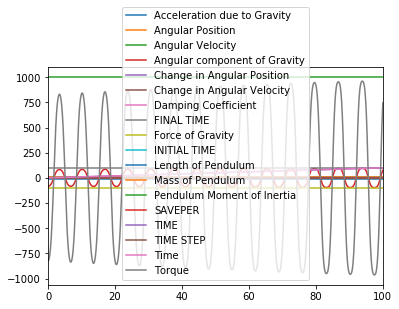

In [32]:
res = model.run()
res.plot()

/Users/houghton/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


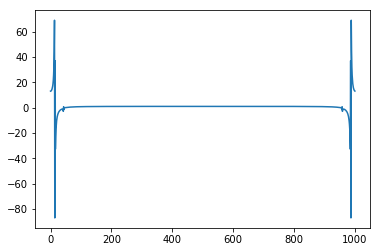

In [34]:
t_series = res['Angular Position']
#def is_periodic(t_series):
fft = np.fft.fft(t_series)
plt.plot(fft)


(array([ 32, 158]), array([ 1.6,  7.9]), array([ 0.9995736 ,  0.99894134]))

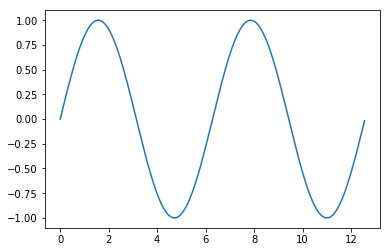

In [38]:
from scipy import signal
xs = np.arange(0, 4*np.pi, 0.05)
data = np.sin(xs)
plt.plot(xs, data)
peakind = signal.find_peaks_cwt(data, np.arange(1,10))
peakind, xs[peakind], data[peakind]

In [42]:
peakind = signal.find_peaks_cwt(t_series, np.arange(1,10))
multiple_peaks = len(peakind) > 1
multiple_peaks

True

In [64]:
segment = int(np.mean(np.diff(peakind))/8)
segment

8

In [66]:
measure = np.mean([t_series.autocorr(i) for i in range(1,segment)])
measure > .75

True

In [17]:
a = pd.DataFrame(np.ones((3,3)))
a['hi'] = 3
a
(a.index==2).argmax()


2

In [22]:
model = pysd.read_vensim('tests/test-models/samples/teacup/teacup.mdl')
model.doc()

,Real Name,Py Name,Unit,Comment
0,Characteristic Time,characteristic_time,Minutes,
1,Heat Loss to Room,heat_loss_to_room,Degrees/Minute,This is the rate at which heat flows from the ...
2,Room Temperature,room_temperature,,
3,Teacup Temperature,teacup_temperature,Degrees,
4,FINAL TIME,final_time,Minute,The final time for the simulation.
5,INITIAL TIME,initial_time,Minute,The initial time for the simulation.
6,SAVEPER,saveper,"Minute [0,?]",The frequency with which output is stored.
7,TIME STEP,time_step,"Minute [0,?]",The time step for the simulation.


In [26]:
model = pysd.read_vensim('tests/test-models/samples/teacup/teacup.mdl')
result0 = model.run()
result1 = model.run(params={'Room Temperature': 1000})
result2 = model.run()
model.reload()
result3 = model.run()

self.assertTrue((result0 == result3).all().all())
self.assertFalse((result0 == result1).all().all())
self.assertTrue((result1 == result2).all().all())

AttributeError: 'Model' object has no attribute 'reload'

In [ ]:
model.

In [21]:
model.run()

,Characteristic Time,FINAL TIME,Heat Loss to Room,INITIAL TIME,Room Temperature,SAVEPER,TIME,TIME STEP,Teacup Temperature,Time
0.000,10,30,11.000000,0,70,0.125,0.000,0.125,180.000000,0.000
0.125,10,30,10.862500,0,70,0.125,0.125,0.125,178.625000,0.125
0.250,10,30,10.726719,0,70,0.125,0.250,0.125,177.267188,0.250
0.375,10,30,10.592635,0,70,0.125,0.375,0.125,175.926348,0.375
0.500,10,30,10.460227,0,70,0.125,0.500,0.125,174.602268,0.500
0.625,10,30,10.329474,0,70,0.125,0.625,0.125,173.294740,0.625
0.750,10,30,10.200356,0,70,0.125,0.750,0.125,172.003556,0.750
0.875,10,30,10.072851,0,70,0.125,0.875,0.125,170.728511,0.875
1.000,10,30,9.946940,0,70,0.125,1.000,0.125,169.469405,1.000
1.125,10,30,9.822604,0,70,0.125,1.125,0.125,168.226037,1.125


In [6]:
d = {'a':1, 'b':2}

In [10]:
for key, val in d.items():
    print(key, val)

a 1
b 2


In [11]:
import time
time.time()

1499715812.290142

In [15]:
class MyObj(object):
    def __init__(self):
        self.inittime = time.time()
        
    def reload_self(self):
        self.__init__()
    

In [16]:
a = MyObj()
a.inittime

1499715987.2452679

In [17]:
a.reload_self()
a.inittime

1499715988.093183